# Data processing for vineyard

**Vineyard index scales**

| Índices                             | Clases            | Rango de valores | Clases ID         |
|-------------------------------------|-------------------|------------------|-------------------|
|**Índice Huglin o Heliotérmico (HI)**| Muy cálido        | HI > 3000        | HI+3              |
|                                     | Cálido            | 2400 < HI ≤ 3000 | HI+2              |
|                                     | Templado cálido   | 2100 < HI ≤ 2400 | HI+1              |
|                                     | Templado          | 1800 < HI ≤ 2100 | HI-1              |
|                                     | Fresco            | 1500 < HI ≤ 1800 | HI-2              |
|                                     | Muy Fresco        | HI ≤ 1500        | HI-3              |
|                                     |                   |                  |                   |                   
|**Índice de Frescor Nocturno(CI)**   | Muy fresco        | CI ≤ 12          | CI+2              |
|                                     | Fresco            | 12 < CI ≤ 14     | CI+1              |
|                                     | Templado          | 14 < CI ≤ 18     | CI-1              |
|                                     | Cálido            | CI > 18          | CI-2              |
|                                     |                   |                  |                   |
|**Índice de Sequía (DI)**            | Muy seco          | DI ≤-200         | DI+3              |
|                                     | Seco              | -200 < DI ≤ -100 | DI+2              |
|                                     | Moderadamente seco| -100 < DI ≤ 50   | DI+1              |
|                                     | Sub húmedo        | 50 < DI ≤150     | DI-1              |
|                                     | Húmedo            | DI > 150         | DI-2              |

**ZONA DE ALTO POTENCIAL VITÍCOLA:**
- **Índice de Huglin**: clases de clima muy fresco (HI-3), fresco (HI-2), templado (HI-1) y clase de clima templado cálido (HI+1).
- **Índice de Frescor Nocturno**: clases de clima con noches frescas (CI+1) y muy frescas (CI+2).
- **Índice de Sequía**: clases de clima sub-húmedo (DI-1) y moderadamente seco (DI+1).

**scenarios' equivalences**

RCPs and SSPs, resulting in four suggestions of suitable combinations, mapping: 
- (i) A2 world onto RCP 8.5 and SSP3
- (ii) B2 (or A1B) world onto RCP 6.0 and SSP2
- (iii) B1 world onto RCP 4.5 and SSP1
- (iv) A1FI world onto RCP 8.5 and SSP5

# Setup
## Library import
We import all the required Python libraries

In [2]:

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely.geometry import box
from tqdm import tqdm

# Data import

In [40]:
## Spain
spain = gpd.read_file('../../datasets/processed/spain.geojson', driver='GeoJSON')

<AxesSubplot:>

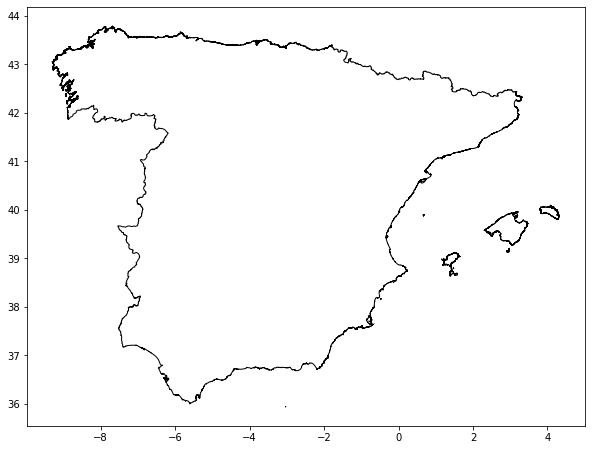

In [42]:
fig, ax = plt.subplots(figsize=(10,10))
spain.plot(ax=ax, color='w', edgecolor='k')

## Frescor Nocturno 
**Read data**

In [20]:
layerlist = fiona.listlayers('../../datasets/raw/crops/vino/Resumen FRESCOR.dbf')
layerlist

['Resumen FRESCOR']

In [21]:
df_frescor = gpd.read_file('../../datasets/raw/crops/vino/Resumen FRESCOR.dbf', driver="FileDBF", layer=layerlist[0])
df_frescor = df_frescor[['DENOMINACI', 'LONG', 'LAT', 'ALTURA', 'N1971_2000', 'MEDIA', 'A1B', 'A2', 'B1', 'geometry']]
df_frescor

,DENOMINACI,LONG,LAT,ALTURA,N1971_2000,MEDIA,A1B,A2,B1,geometry
0,1.0,-5.6,36.0,228.93,19.00,20.26,20.37,20.10,20.14,None
1,2.0,-5.4,36.0,143.71,18.92,20.15,20.26,19.99,20.03,None
2,3.0,-6.0,36.2,62.26,19.95,21.31,21.44,21.09,21.17,None
3,4.0,-5.8,36.2,75.97,19.14,20.48,20.60,20.26,20.35,None
4,5.0,-5.6,36.2,270.90,18.01,19.26,19.38,19.08,19.11,None
...,...,...,...,...,...,...,...,...,...,...
1440,1441.0,-5.4,43.6,114.55,14.62,15.97,16.10,15.94,15.73,None
1441,1442.0,-5.2,43.6,41.89,14.75,16.14,16.29,16.06,15.86,None
1442,1443.0,-8.0,43.8,275.28,12.96,14.08,14.20,14.01,13.86,None
1443,1444.0,-7.8,43.8,88.86,12.78,13.89,14.01,13.81,13.68,None


**Create grid**

In [26]:
gdf_frescor = gpd.GeoDataFrame(df_frescor, geometry=gpd.points_from_xy(df_frescor.LONG, df_frescor.LAT))
gdf_frescor = gdf_frescor.set_crs("EPSG:4326")

In [27]:
# total area for the grid
xmin, ymin, xmax, ymax= gdf_frescor.total_bounds
# how many cells across and down
n_cells=gdf_frescor['LONG'].nunique()
cell_size = (xmax-xmin)/n_cells
# projection of the grid
crs = "EPSG:4326"#"+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs"
# create the cells in a loop
grid_cells = []
for x0 in np.arange(xmin, xmax+cell_size, cell_size ):
    for y0 in np.arange(ymin, ymax+cell_size, cell_size):
        # bounds
        x1 = x0-cell_size
        y1 = y0+cell_size
        grid_cells.append(box(x0+cell_size*0.5, y0-cell_size*0.5, x1+cell_size*0.5, y1-cell_size*0.5)  )
cell = gpd.GeoDataFrame(grid_cells, columns=['geometry'], crs=crs)

<AxesSubplot:>

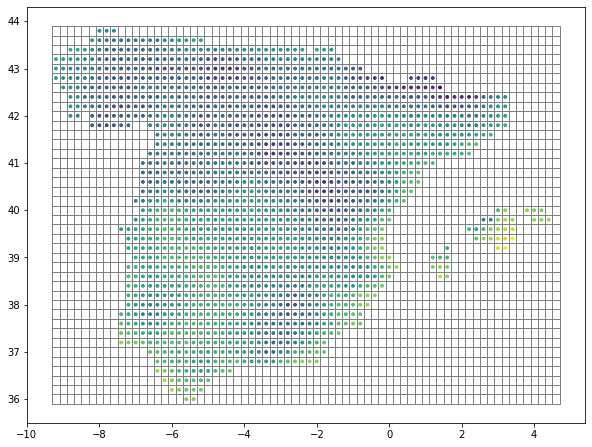

In [28]:
fig, ax = plt.subplots(figsize=(10,10))
cell.plot(ax=ax, facecolor="none", edgecolor='grey')
gdf_frescor.plot(ax=ax, column='MEDIA', markersize=8)

**Intersect points with grid**

In [29]:
polygons = []
sindex = cell.sindex
# Iterate over the geometries
for n, geometry in enumerate(tqdm(gdf_frescor.geometry)):

    # Find approximate matches with r-tree
    possible_matches_index = list(sindex.intersection(geometry.bounds))
    possible_matches = cell.iloc[possible_matches_index]
    # Find precise matches with r-tree
    polygons.append(possible_matches[possible_matches.intersects(geometry)]['geometry'].iloc[0])

100%|██████████| 1445/1445 [00:01<00:00, 1017.12it/s]


In [30]:
gdf_frescor['geometry'] = polygons

<AxesSubplot:>

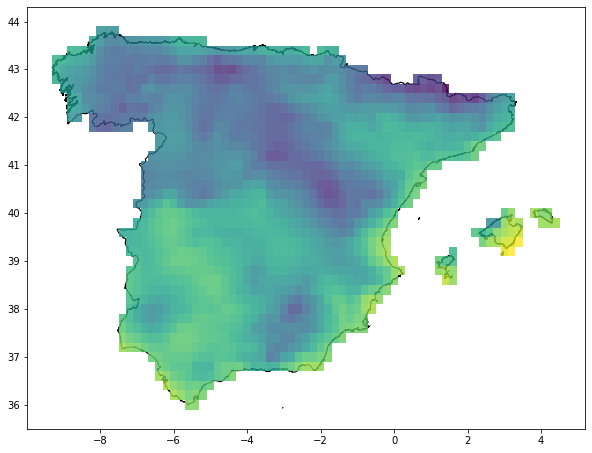

In [46]:
fig, ax = plt.subplots(figsize=(10,10))
spain.plot(ax=ax, color='w', edgecolor='k')
gdf_frescor.plot(ax=ax, column='MEDIA', alpha=0.8)

**Intersect grid with spain**

In [85]:
gdf_frescor = gdf_frescor.overlay(gpd.GeoDataFrame({'geometry':spain.simplify(0.005)}), how='intersection')

<AxesSubplot:>

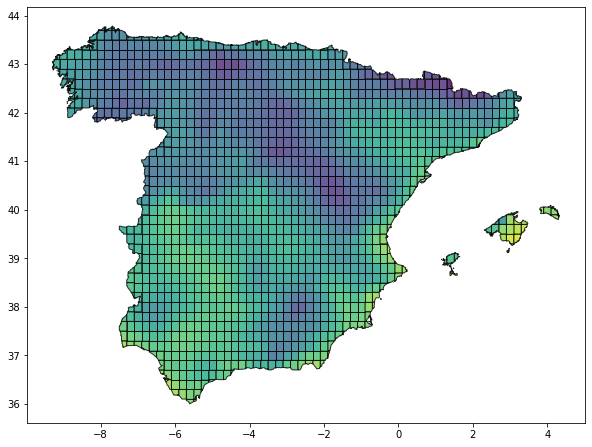

In [86]:
fig, ax = plt.subplots(figsize=(10,10))
gdf_frescor.plot(ax=ax, column='MEDIA', alpha=0.8, edgecolor='k')

### Add index classes

| Índices                             | Clases            | Rango de valores | Clases ID         |
|-------------------------------------|-------------------|------------------|-------------------|                 
|**Índice de Frescor Nocturno(CI)**   | Muy fresco        | CI ≤ 12          | CI+2              |
|                                     | Fresco            | 12 < CI ≤ 14     | CI+1              |
|                                     | Templado          | 14 < CI ≤ 18     | CI-1              |
|                                     | Cálido            | CI > 18          | CI-2              |

In [94]:
def CI_index_classes(x):
    if x <= 12:
        return 'CI+2'
    if (x > 12) and (x <= 14):
        return 'CI+1'
    if (x > 14) and (x <= 18):
        return 'CI-1'
    if x > 18:
        return 'CI-2'

In [101]:
for scenario in ['N1971_2000', 'MEDIA', 'A1B', 'A2', 'B1']:
    print(scenario)
    gdf_frescor[f'{scenario}_class'] = gdf_frescor[scenario].apply(lambda x: CI_index_classes(x))

N1971_2000
MEDIA
A1B
A2
B1


<AxesSubplot:>

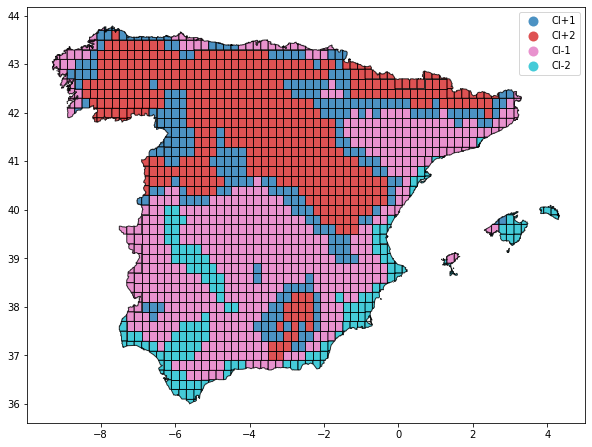

In [107]:
fig, ax = plt.subplots(figsize=(10,10))
gdf_frescor.plot(ax=ax, column='MEDIA_class', alpha=0.8, edgecolor='k', legend=True)

## Huglin 
**Read data**

In [22]:
layerlist = fiona.listlayers('../../datasets/raw/crops/vino/Resumen Huglin.dbf')
layerlist

['Resumen Huglin']

In [23]:
df_huglin = gpd.read_file('../../datasets/raw/crops/vino/Resumen Huglin.dbf', driver="FileDBF", layer=layerlist[0])
df_huglin = df_huglin[['DENOMINACI', 'LONG', 'LAT', 'ALTURA', 'N1971_2000', 'MEDIA', 'A1B', 'A2', 'B1', 'geometry']]
df_huglin

,DENOMINACI,LONG,LAT,ALTURA,N1971_2000,MEDIA,A1B,A2,B1,geometry
0,1.0,-5.6,36.0,228.93,2079.05,2306.05,2322.15,2211.63,2327.29,None
1,2.0,-5.4,36.0,143.71,2150.34,2376.45,2392.96,2286.38,2394.18,None
2,3.0,-6.0,36.2,62.26,2317.59,2565.03,2585.36,2458.09,2584.47,None
3,4.0,-5.8,36.2,75.97,2341.20,2586.96,2607.63,2480.11,2605.60,None
4,5.0,-5.6,36.2,270.90,2166.85,2397.34,2419.70,2293.55,2410.43,None
...,...,...,...,...,...,...,...,...,...,...
1440,1441.0,-5.4,43.6,114.55,1482.62,1693.18,1698.11,1645.05,1711.21,None
1441,1442.0,-5.2,43.6,41.89,1595.80,1802.61,1807.50,1757.12,1819.15,None
1442,1443.0,-8.0,43.8,275.28,1237.81,1404.75,1409.99,1369.06,1414.63,None
1443,1444.0,-7.8,43.8,88.86,1434.68,1604.90,1611.24,1564.11,1615.43,None


**Create grid**

In [34]:
gdf_huglin = gpd.GeoDataFrame(df_huglin, geometry=gpd.points_from_xy(df_huglin.LONG, df_huglin.LAT))
gdf_huglin = gdf_huglin.set_crs("EPSG:4326")

In [35]:
gdf_huglin['geometry'] = polygons

<AxesSubplot:>

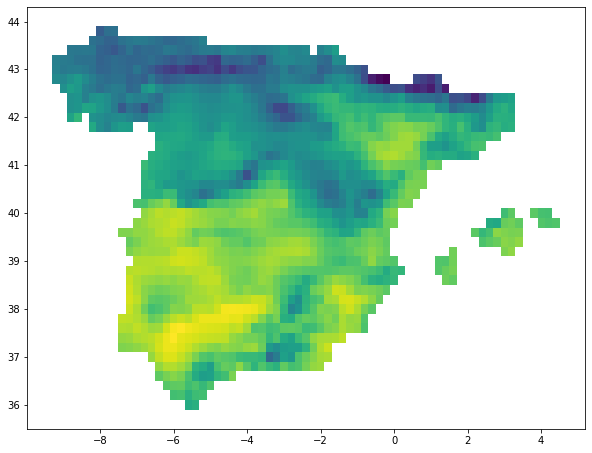

In [36]:
fig, ax = plt.subplots(figsize=(10,10))
gdf_huglin.plot(ax=ax, column='MEDIA')

**Intersect grid with spain**

In [87]:
gdf_huglin = gdf_huglin.overlay(gpd.GeoDataFrame({'geometry':spain.simplify(0.005)}), how='intersection')

<AxesSubplot:>

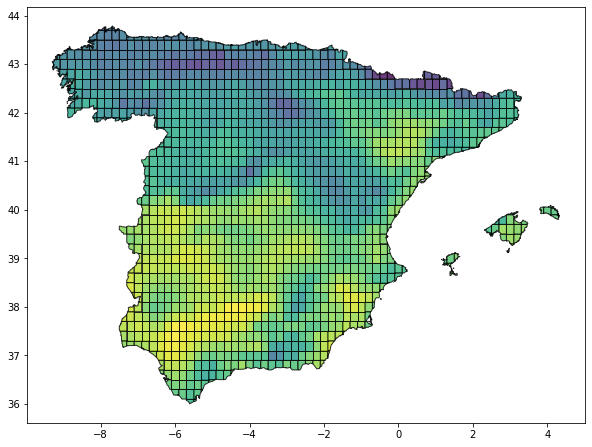

In [88]:
fig, ax = plt.subplots(figsize=(10,10))
gdf_huglin.plot(ax=ax, column='MEDIA', alpha=0.8, edgecolor='k')

### Add index classes

| Índices                             | Clases            | Rango de valores | Clases ID         |
|-------------------------------------|-------------------|------------------|-------------------|
|**Índice Huglin o Heliotérmico (HI)**| Muy cálido        | HI > 3000        | HI+3              |
|                                     | Cálido            | 2400 < HI ≤ 3000 | HI+2              |
|                                     | Templado cálido   | 2100 < HI ≤ 2400 | HI+1              |
|                                     | Templado          | 1800 < HI ≤ 2100 | HI-1              |
|                                     | Fresco            | 1500 < HI ≤ 1800 | HI-2              |
|                                     | Muy Fresco        | HI ≤ 1500        | HI-3              |

In [96]:
def HI_index_classes(x):
    if x > 3000:
        return 'HI+3'
    if (x > 2400) and (x <= 3000):
        return 'HI+2'
    if (x > 2100) and (x <= 2400):
        return 'HI+1'
    if (x > 1800) and (x <= 2100):
        return 'HI-1'
    if (x > 1500) and (x <= 1800):
        return 'HI-2'
    if x <= 1500:
        return 'HI-3'

In [104]:
for scenario in ['N1971_2000', 'MEDIA', 'A1B', 'A2', 'B1']:
    print(scenario)
    gdf_huglin[f'{scenario}_class'] = gdf_huglin[scenario].apply(lambda x: HI_index_classes(x))

N1971_2000
MEDIA
A1B
A2
B1


<AxesSubplot:>

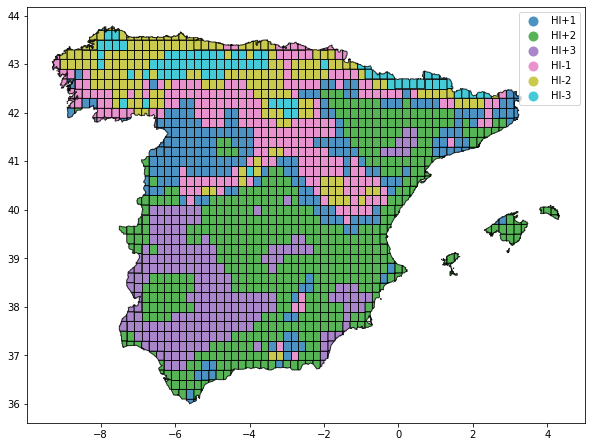

In [106]:
fig, ax = plt.subplots(figsize=(10,10))
gdf_huglin.plot(ax=ax, column='MEDIA_class', alpha=0.8, edgecolor='k', legend=True)

## Sequía
**Read data**

In [17]:
layerlist = fiona.listlayers('../../datasets/raw/crops/vino/Resumen IS.dbf')
layerlist

['Resumen IS']

In [18]:
df_is = gpd.read_file('../../datasets/raw/crops/vino/Resumen IS.dbf', driver="FileDBF", layer=layerlist[0])
df_is = df_is[['DENOMINACI', 'LONG', 'LAT', 'ALTURA', 'N1971_2000', 'MEDIA', 'A1B', 'A2', 'B1', 'geometry']]
df_is

,DENOMINACI,LONG,LAT,ALTURA,N1971_2000,MM5_CNCM3_,MM5_CNCM32,MM5_ECHAM_,MM5_ECHAM2,MM5_ECHAM3,...,REM_ECHAM2,WRA_ECHAM5,WRA_ECHAM2,WRB_ECHAM5,MEDIA,VARIACI_N,A1B,A2,B1,geometry
0,1.0,-5.6,36.0,228.93,47.67,46.84,49.83,23.14,35.20,48.10,...,12.43,9.71,22.36,10.19,20.20,-27.47,12.39,30.17,31.40,None
1,2.0,-5.4,36.0,143.71,47.32,28.75,30.80,5.47,17.49,30.05,...,4.21,-7.81,4.63,-7.30,2.60,-44.72,-5.18,9.81,15.39,None
2,3.0,-6.0,36.2,62.26,44.07,11.32,25.34,9.17,17.61,29.53,...,5.93,-2.23,4.64,-2.59,4.21,-39.85,-4.62,17.79,15.49,None
3,4.0,-5.8,36.2,75.97,28.97,-7.71,4.27,-10.56,-1.52,9.46,...,-23.46,-20.03,-12.66,-20.23,-16.17,-45.14,-24.62,-1.73,-6.22,None
4,5.0,-5.6,36.2,270.90,51.98,13.53,29.24,1.27,22.25,32.04,...,-3.95,-5.73,7.71,-5.03,0.90,-51.08,-8.46,14.43,13.37,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1440,1441.0,-5.4,43.6,114.55,257.09,183.43,194.64,217.44,232.54,221.34,...,190.14,210.01,207.84,209.20,196.37,-60.73,192.64,211.83,195.27,None
1441,1442.0,-5.2,43.6,41.89,255.20,179.07,189.55,212.05,226.88,215.91,...,189.63,204.92,201.07,203.94,192.25,-62.95,187.25,211.48,191.73,None
1442,1443.0,-8.0,43.8,275.28,350.15,252.18,270.30,313.03,314.19,319.58,...,283.15,306.43,295.78,304.07,289.40,-60.75,287.32,295.82,290.13,None
1443,1444.0,-7.8,43.8,88.86,260.76,162.54,178.97,218.90,220.19,225.53,...,195.74,207.20,203.36,205.45,198.40,-62.35,195.89,204.78,200.10,None


**Create gridd**

In [37]:
gdf_is = gpd.GeoDataFrame(df_is, geometry=gpd.points_from_xy(df_is.LONG, df_is.LAT))
gdf_is = gdf_is.set_crs("EPSG:4326")

In [38]:
gdf_is['geometry'] = polygons

<AxesSubplot:>

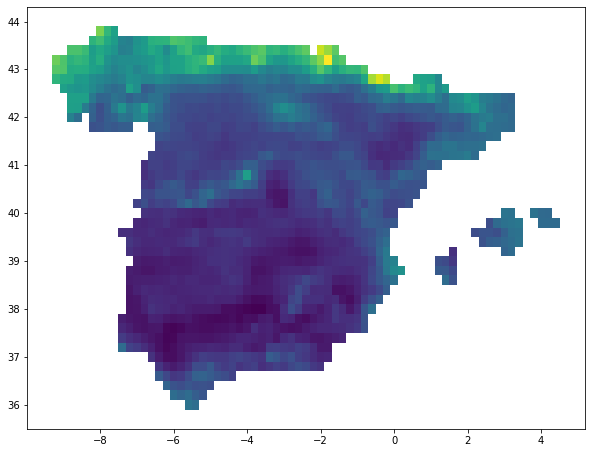

In [39]:
fig, ax = plt.subplots(figsize=(10,10))
gdf_is.plot(ax=ax, column='MEDIA')

**Intersect grid with spain**

In [89]:
gdf_is = gdf_is.overlay(gpd.GeoDataFrame({'geometry':spain.simplify(0.005)}), how='intersection')

<AxesSubplot:>

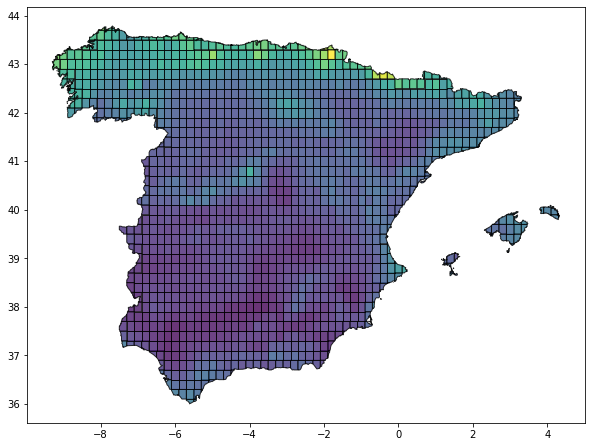

In [90]:
fig, ax = plt.subplots(figsize=(10,10))
gdf_is.plot(ax=ax, column='MEDIA', alpha=0.8, edgecolor='k')

### Add index classes

| Índices                             | Clases            | Rango de valores | Clases ID         |
|-------------------------------------|-------------------|------------------|-------------------|
|**Índice de Sequía (DI)**            | Muy seco          | DI ≤-200         | DI+3              |
|                                     | Seco              | -200 < DI ≤ -100 | DI+2              |
|                                     | Moderadamente seco| -100 < DI ≤ 50   | DI+1              |
|                                     | Sub húmedo        | 50 < DI ≤150     | DI-1              |
|                                     | Húmedo            | DI > 150         | DI-2              |

In [97]:
def DI_index_classes(x):
    if x <= -200:
        return 'DI+3'
    if (x > -200) and (x <= -100):
        return 'DI+2'
    if (x > -100) and (x <= 50):
        return 'DI+1'
    if (x > 50) and (x <= 150):
        return 'DI-1'
    if x > 150:
        return 'DI-2'

In [108]:
for scenario in ['N1971_2000', 'MEDIA', 'A1B', 'A2', 'B1']:
    print(scenario)
    gdf_is[f'{scenario}_class'] = gdf_is[scenario].apply(lambda x: DI_index_classes(x))

N1971_2000
MEDIA
A1B
A2
B1


<AxesSubplot:>

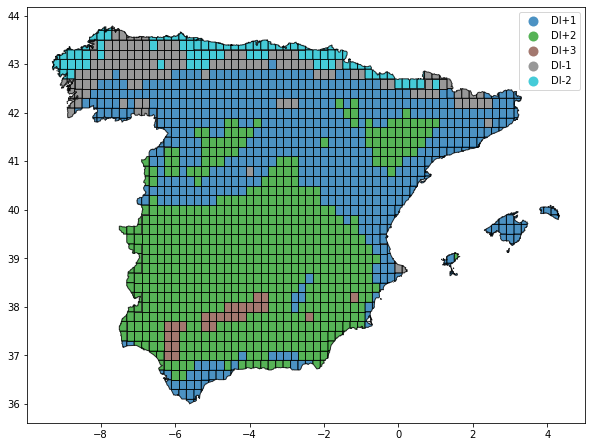

In [109]:
fig, ax = plt.subplots(figsize=(10,10))
gdf_is.plot(ax=ax, column='MEDIA_class', alpha=0.8, edgecolor='k', legend=True)